<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [127]:
import requests
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import sys
import time
from time import sleep

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

***These functions will extract location, company, job, summary and salary. 
In anticipation of errors, I will use try/except to return a 'None' where the data is not available.***

In [3]:
Function to extract location

def get_loc(result):
    try:
        return result.find('div', class_ = 'companyLocation').text.strip()
    except:
        return 'None'

In [4]:
# Function to extract company 

def get_comp(result):
    try:
        return result.find('span', class_ = 'companyName').text.strip()
    except:
        return 'None'

In [5]:
# Function to extract job title 

def get_job(result):
    try:
        return result.find('a').text.strip()
    except:
        return 'None'

In [6]:
# Function to extract salary 

def get_sal(result):
    try:
        return result.find('div', class_ = 'metadata salary-snippet-container').text.strip()
    except:
        return 'None'

In [7]:
# Function to extract job description 

def get_summ(result):
    try:
        return result.find('table', class_ ='jobCardShelfContainer big6_visualChanges').text.strip().replace('\n','')
    except:
        return 'None'

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [8]:
cities = ['New+York', 'New+Jersey', 'Baltimore', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'San+Jose', 'San+Diego', 'Los+Angeles', 'Washington%2C+DC',
          'Boston', 'Pittsburgh', 'Philadelphia', 'Atlanta', 'Cincinnati', 'St.+Louis', 'Tampa', 'Oakland',
          'Houston', 'Dallas', 'Albuquerque', 'Portland', 'Denver', 'Phoenix', 'Minneapolis', 'Miami',
          'Charlotte', 'Phoenix', 'Jacksonville', 'Indianapolis', 'Nashville', 'Kansas+City', 'Columbus']
len(cities)

34

***The code below will loop through each city in the cities list, and through each page of the search
results for that city.***
- The code limits the results to a 2000 job postings per city.
- The job postings extracted are appended to the results list.
- sleep 1 sec between each url request

In [10]:
max_results_per_city = 3000

results = []

for city in cities:
    for start in range(0, max_results_per_city, 100):
        headers = {'User_Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.4 Safari/605.1.15'}
        url = f'https://www.indeed.com/jobs?q=data%20scientist&l={city}&start={start}'
        r = requests.get(url, headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        for result in soup.find_all('div', class_ = 'cardOutline'):
            results.append(result)
        sleep(1)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [11]:
jobs = pd.DataFrame(columns=['location', 'title', 'company', 'salary', 'summary'])

In [12]:
for item in results:
    location = get_loc(item)
    title = get_job(item)
    company = get_comp(item)
    salary = get_sal(item)
    summary = get_summ(item)
    jobs.loc[len(jobs)] = [location, title, company, salary, summary]

In [13]:
# save scraped results as a csv file
jobs.to_csv('jobs.csv')

In [17]:
Load more scraped results
jobs1 = pd.read_csv('jobs1.csv')

In [40]:
jobs1.shape

(77865, 5)

##### I was able to scraped about 98,000 rows of data howerer, I have had some issues with my dataset duribg the data cleansing part and will be using the raw data provided by GA

### Load and Clean the data

In [68]:
# Load in raw data from GA
df = pd.read_csv('raw_data.csv')

In [69]:
#  Make a back-up copy of the dataframe. A lesson learnt from not backing up the jobs and jobs1 datasets
df_back_up = df.copy()

***EDA of the dataset***

In [70]:
df.head()

,Unnamed: 0,Location,Title,Company,Salary,Description,City,jobs
0,0,NaN,Business Intelligence Analyst,Dynamic Planner,"£32,000 - £40,000 a year","Provision of accurate, accessible, and impactf...",Exeter,business+intelligence
1,1,NaN,Senior HR Advisor *Based in the South West* Pe...,Sitel,"£26,000 - £28,000 a year",We offer benefits to keep you healthy and happ...,Exeter,business+intelligence
2,2,NaN,Business Development Executive,Sigma Software Distribution,"£18,500 a year",Generate new business sales and opportunities:...,Exeter,business+intelligence
3,3,NaN,French Customer Service Advisor based in Exete...,Sitel,£10.50 an hour,We offer benefits to keep you healthy and happ...,Exeter,business+intelligence
4,4,NaN,German Customer Service Adviser based in Exete...,Sitel,£10.50 an hour,We offer benefits to keep you healthy and happ...,Exeter,business+intelligence


In [71]:
df.tail()

,Unnamed: 0,Location,Title,Company,Salary,Description,City,jobs
83384,83384,Bourton on the Water,Sales Administrator,The Burford Recruitment Company,"£20,000 - £22,000 a year","Maintaining the database and other systems, ke...",Oxford,database+administrator
83385,83385,Marlow SL7 1DA,SharePoint Experience Manager,Softcat,NaN,Ability to collaborate and work with other dev...,Oxford,database+administrator
83386,83386,Berkshire,Office Manager/Team Admin (Maternity Cover) - ...,BNP Paribas,NaN,"Conduct reviews of telecoms leases, recording ...",Oxford,database+administrator
83387,83387,Reading,Cloud Solution Architect - Data and AI,Microsoft,NaN,Enterprise-scale technical experience with clo...,Oxford,database+administrator
83388,83388,Watchfield,Linux DevOps Engineer,Prolinx Limited,"£47,500 - £55,000 a year",Prolinx technical staff engage with and provid...,Oxford,database+administrator


In [72]:
df.shape

(83389, 8)

In [73]:
df.describe()

,Unnamed: 0
count,83389.000000
mean,41694.000000
std,24072.475136
min,0.000000
25%,20847.000000
50%,41694.000000
75%,62541.000000
max,83388.000000


In [74]:
df.isnull().sum()

Unnamed: 0         0
Location        8317
Title              0
Company            1
Salary         48466
Description        0
City               0
jobs               0
dtype: int64

***There are 8,317 observations without the location information and 48,466 observations with salary information. 1 observation without company information. These will need to be cleaned***

In [75]:
# Review how many jobs have salary information for each city
df.groupby('City')[['Salary']].count()

,Salary
City,
Bath,2630
Belfast,939
Birmingham,2587
Bristol,2957
Cambridge,2007
Cardiff,2798
Edinburgh,1649
Exeter,3268
Glasgow,2021


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

In [77]:
# Look at the Salary Column in greater detail
df['Salary'].value_counts()

£40,000 - £50,000 a year    1142
£25,000 - £35,000 a year     635
£50,000 - £60,000 a year     633
£30,000 a year               608
£30,000 - £40,000 a year     600
                            ... 
£49,000 - £74,000 a year       1
£21.30 an hour                 1
£88,000 a year                 1
£48,114 - £52,560 a year       1
£28,070 a year                 1
Name: Salary, Length: 1268, dtype: int64

In [ ]:
# Drop duplicate rows from df and keep the first instance of each duplicate row
# This drop will include the duplicate data scraped for cities with less than 3,000 jobs
# Note, I am only dropping rows that have duplicate city, location, job title, company and salary data
# I've captured the number of company reviews and job summaries as additional fields, and won't 
# consider these fields in the identification of duplicate rows
print(f'DF shape before dropping duplicates: {df.shape}')
df.drop_duplicates(subset=
                   ['City', 'Location', 'Title', 'Company', 'Salary'], keep='first', inplace=True)
print(f'DF shape after dropping duplicates: {df.shape}')

In [78]:
df.dtypes

Unnamed: 0      int64
Location       object
Title          object
Company        object
Salary         object
Description    object
City           object
jobs           object
dtype: object

In [79]:
# Drop unnamed column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [82]:
# Drop duplicate rows with duplicate Location, Title, Company, Salary and City from my dataset.
# And keep the first instance of each duplicate row 

df.drop_duplicates(subset=['Location', 'Title', 'Company', 'Salary','City'], keep='first', inplace=True)
df.shape

(12416, 7)

In [83]:
df['Salary'].value_counts()

£30,000 - £35,000 a year    97
£40,000 - £50,000 a year    95
£30,000 a year              94
£25,000 - £30,000 a year    81
£40,000 - £45,000 a year    72
                            ..
£71,000 - £85,000 a year     1
£35,054 - £38,558 a year     1
£59,790 - £63,285 a year     1
£36,270 - £40,300 a year     1
£22.45 a day                 1
Name: Salary, Length: 1268, dtype: int64

In [84]:
# Remove rows where Salary is None
mask = df.Salary.notnull()
df = df.loc[mask,:]
df.shape

(4626, 7)

In [ ]:
# The description and jobs features were not considered when dropping duplicate rows as they have
# little or no effect on our objective.
# In dataframe df1 further below, I will drop the "Location" column and use "City". 

In [88]:
df['Location'].unique()

array([nan, 'Exeter', 'Exeter EX2 7HR', 'Buckfastleigh',
       'Uffculme EX15 3FH', 'South West', 'Newton Abbot', 'Bridgend',
       'Cardiff CF10', 'Portishead BS20', 'Newport', 'Pontypool NP4 0XJ',
       'Cardiff', 'Cardiff CF10 1FS', 'Bristol BS20 7XJ', 'Llanrumney ED',
       'Bristol BS13 7AT', 'Glascoed', 'Bridgend CF35 5HY',
       'Bristol BS3 2HQ', 'Bristol BS8 1QU', 'Caerphilly CF83',
       'Cardiff CF24 5EA', 'Avonmouth', 'Weston-super-Mare',
       'Caldicot NP26 5PS', 'Cambridge', 'Cambridge CB2 0QQ',
       'Huntingdon', 'Cambridgeshire', 'Huntingdon PE28 2EA',
       'Cambridge CB4 3AZ', 'Stevenage SG1 2AD', 'Stevenage SG1',
       'Stevenage', 'Sutton Coldfield', 'Birmingham B5 6SN', 'Birmingham',
       'Birmingham B16 9RG', 'Coventry CV1 3BH', 'Evesham WR11 8TZ',
       'Worcester WR1 2ET', 'Coventry CV4 8JA', 'Coventry CV2',
       'Warwickshire', 'West Bromwich B71 4DL', 'Solihull B90 4RZ',
       'Birmingham B18 5JA', 'Wolverhampton', 'Birmingham B1', 'Coventry'

In [89]:
df['City'].unique()

array(['Exeter', 'Cardiff', 'Cambridge', 'Birmingham', 'Liverpool',
       'Bristol', 'London', 'Edinburgh', 'Leeds', 'Newcastle',
       'Manchester', 'Glasgow', 'Belfast', 'Bath', 'Oxford'], dtype=object)

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [86]:
# Find entries with annual salaries by removing rows where Salary is not specified as an annual figure
mask = df.Salary.str.contains('a year')
df = df.loc[mask,:]
df.shape

(4203, 7)

In [93]:
df.head(50)

,Location,Title,Company,Salary,Description,City,jobs
0,NaN,Business Intelligence Analyst,Dynamic Planner,"£32,000 - £40,000 a year","Provision of accurate, accessible, and impactf...",Exeter,business+intelligence
1,NaN,Senior HR Advisor *Based in the South West* Pe...,Sitel,"£26,000 - £28,000 a year",We offer benefits to keep you healthy and happ...,Exeter,business+intelligence
2,NaN,Business Development Executive,Sigma Software Distribution,"£18,500 a year",Generate new business sales and opportunities:...,Exeter,business+intelligence
5,NaN,Customer Sales Advisor,PPP Taking Care Ltd,"£22,000 a year",Pro active and efficient call handling in line...,Exeter,business+intelligence
6,NaN,Army Officer,The Army,"£32,800 a year","A starting salary of around £27,200 which will...",Exeter,business+intelligence
7,Exeter,Graduate Operational Management Programme,South West Water,"£25,000 a year","Joining us on a full-time, permanent basis, yo...",Exeter,business+intelligence
8,Exeter EX2 7HR,Graduate Operational Management Programme,Graduate,"£25,000 a year","Joining us on a full-time, permanent basis, yo...",Exeter,business+intelligence
11,Exeter,Junior Project Manager,OfficeLabs,"£28,000 - £35,000 a year",OfficeLabs are an information management & tec...,Exeter,business+intelligence
13,NaN,Research Analyst - Portuguese Speaking,Metrica Recruitment,"£28,000 - £36,000 a year",This boutique business have a 20 year history ...,Exeter,business+intelligence
15,Exeter,Business Development Manager,YTKO Ltd,"£48,000 - £54,000 a year",Business development: 4 years (Preferred).\nYo...,Exeter,business+intelligence


In [92]:
df.tail(50)

,Location,Title,Company,Salary,Description,City,jobs
81940,Bristol,Senior SIPP Administrator,IDEX Consulting,"£20,000 - £28,000 a year",Usage of internal database for accurate record...,Bath,database+administrator
81941,Bath,Research Nurse/AHP (Ageing and Parkinson's dis...,Royal United Hospitals Bath NHS Foundation Trust,"£31,365 - £37,890 a year",We are looking for research nurse or Allied He...,Bath,database+administrator
81942,Bristol BS37 7LB,Sales Administrator,Western Global,"£19,000 - £20,000 a year",The Sales administrator will handle all admini...,Bath,database+administrator
81944,Bristol BS1 3AG,Operations Administrator/PA to Directors,Foxtek,"£22,000 - £24,000 a year",Manage the company’s internal HR database and ...,Bath,database+administrator
81945,Chipping Sodbury,Empty House Coordinator,Pertemps Network Group,"£23,000 - £23,500 a year",You will review the asbestos database and plac...,Bath,database+administrator
81948,Glastonbury BA6 9TU,Sales Administrator,Friendly Water,"£17,000 - £18,000 a year",To assist with communications to contacts with...,Bath,database+administrator
81950,Bath,Business Development Executive,Appoint Recruitment,"£19,000 - £20,000 a year",Maintain the company CRM database.\nGood admin...,Bath,database+administrator
81952,Chepstow NP16 6UP,Administrative Assistant,TXO Systems,"£18,000 - £20,000 a year",Assist the Service Delivery Executives with th...,Bath,database+administrator
81953,Bristol,Business Support Coordinator,Alexander Mae South West Ltd,"£23,000 a year",Supplier and sub-contractor approvals and data...,Bath,database+administrator
81954,Cheddar BS27,Service Administrator,Majestic Group,"£16,000 - £19,000 a year",General administration and data entry to our c...,Bath,database+administrator


In [91]:
df['Salary'].unique()

array(['£32,000 - £40,000 a year', '£26,000 - £28,000 a year',
       '£18,500 a year', ..., '£29,000 - £32,000 a year',
       '£47,500 - £55,000 a year', '£33,000 - £49,000 a year'],
      dtype=object)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [109]:
# Function to convert salary string containing a salary or salary range into a single numeric 
# salary figure.  Salary ranges will be converted to the mid-point of that range.

def converted_salary(salary):
        
    # Split salary string at 'a year', and remove '£' and ',' from the 1st item in returned list
    # Then, split this string again at '-', storing the min and max points of the salary range
    # in the salary_range list
    salary_range = salary.split('a year')[0].replace('£','').replace(',','').split('-')

    # If the salary_range has a min and max point (i.e. the length of the salary_range list = 2)
    # return the mid-point of these 2 values as a float
    if len(salary_range) == 2:
        return round((int(salary_range[0]) + int(salary_range[1])) / 2)
    # If the salary_range consists of 1 figure only (i.e. it is not a range), return that 
    # salary figure as a float
    else:
        return round(int(salary_range[0]))

In [110]:
# Convert salary series to numeric salary with the converted_salary function

df1 = df.copy()
df1['Salary'] = df['Salary'].map(converted_salary)

In [111]:
# df1['Salary'] = df1['Salary'].astype(int)

In [112]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4203 entries, 0 to 83361
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Location     3599 non-null   object
 1   Title        4203 non-null   object
 2   Company      4203 non-null   object
 3   Salary       4203 non-null   int64 
 4   Description  4203 non-null   object
 5   City         4203 non-null   object
 6   jobs         4203 non-null   object
dtypes: int64(1), object(6)
memory usage: 262.7+ KB


In [122]:
# check that function worked and that the data type is an integer
df1.head(5)

,Title,Company,Salary,Description,City,jobs
0,Business Intelligence Analyst,Dynamic Planner,36000,"Provision of accurate, accessible, and impactf...",Exeter,business intelligence
1,Senior HR Advisor *Based in the South West* Pe...,Sitel,27000,We offer benefits to keep you healthy and happ...,Exeter,business intelligence
2,Business Development Executive,Sigma Software Distribution,18500,Generate new business sales and opportunities:...,Exeter,business intelligence
5,Customer Sales Advisor,PPP Taking Care Ltd,22000,Pro active and efficient call handling in line...,Exeter,business intelligence
6,Army Officer,The Army,32800,"A starting salary of around £27,200 which will...",Exeter,business intelligence


In [118]:
# Drop the "Location" column
# check that converted_salary function worked and that the data type is an integer
df1.drop(columns=['Location'], inplace=True)

In [121]:
# Lastly, before saving to csv, remove "+" from the "Jobs" feature column
df1['jobs'] = df1['jobs'].map(lambda x: x.replace('+', ' '))
df1.head(5)

,Title,Company,Salary,Description,City,jobs
0,Business Intelligence Analyst,Dynamic Planner,36000,"Provision of accurate, accessible, and impactf...",Exeter,business intelligence
1,Senior HR Advisor *Based in the South West* Pe...,Sitel,27000,We offer benefits to keep you healthy and happ...,Exeter,business intelligence
2,Business Development Executive,Sigma Software Distribution,18500,Generate new business sales and opportunities:...,Exeter,business intelligence
5,Customer Sales Advisor,PPP Taking Care Ltd,22000,Pro active and efficient call handling in line...,Exeter,business intelligence
6,Army Officer,The Army,32800,"A starting salary of around £27,200 which will...",Exeter,business intelligence


***A final check of the dataset before saving as a CSV***

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [128]:
print(df1['Title'].unique())

['Business Intelligence Analyst'
 'Senior HR Advisor *Based in the South West* Permanent'
 'Business Development Executive' 'Customer Sales Advisor' 'Army Officer'
 'Graduate Operational Management Programme' 'Junior Project Manager'
 'Research Analyst - Portuguese Speaking' 'Business Development Manager'
 'Chief Executive' 'Partnerships Executive' 'Tableau MI Analyst'
 'Head of Policy' 'BI Specialist' 'Warehouse and Processing Operative'
 'Senior BI Developer / Lead BI Developer' 'SharePoint Developer'
 'Class 2 Driver' 'Senior BI Developer – UK Home Based – Up to 54,600 pa'
 'Semiconductor Equipment Marketing Director'
 'Senior Analyst Cyber Security'
 'Intern - Performance & Business Intelligence' 'Business Manager'
 'Business Intelligence Developer' 'Anti-Corruption Investigative Officer'
 'Divisional Support Hub Manager'
 'Population and Public Policy Group Business Manager'
 'Deputy Finance Business Partner' 'Business Analyst'
 'Intern - Data Science' 'Data Analyst'
 'Welsh Finan

In [129]:
print(df1['Company'].unique())

['Dynamic Planner' 'Sitel' 'Sigma Software Distribution'
 'PPP Taking Care Ltd' 'The Army' 'South West Water' 'Graduate'
 'OfficeLabs' 'Metrica Recruitment' 'YTKO Ltd' 'Go Beyond Charity'
 'Camden Sawyer Limited t/a Hotel Suppliers' 'FFT Education Ltd'
 'Michael Page UK' 'Acorn Recruitment Limited' 'Olleco'
 'Sanderson Recruitment Plc' 'Bond Williams' 're&m' 'Shackleton Duke'
 'South Wales Police' 'HM Prison & Probation Service'
 'Avon and Somerset Constabulary'
 'UK Government - Office for National Statistics' 'LookAfterMyBills'
 'Melin Homes' 'Welsh Contact Centre Forum Ltd' 'Jomo People Ltd'
 'Blake Morgan LLP' 'BCA' 'Ramsdens Financial Ltd' 'Cardiff University'
 'Bristol Water' 'BAE Systems' 'Cwm Taf Morgannwg University Health Board'
 'Talent Ticker' 'Babcock International' 'Applause IT Ltd'
 'University of Bristol' 'Link Financial Outsourcing'
 'Evolution Recruitment Solutions' 'DWR Cymru Cyfyngedig Welsh Water Plc'
 'The Range - Loss Prevention' 'IntaPeople' 'Meltwater' 'Greyfly

In [100]:
df1['Salary'].unique()

array([ 36000,  27000,  18500,  22000,  32800,  25000,  31500,  32000,
        51000,  57500,  18000,  30000,  82500,  35000,  19890,  48500,
        40000,  28000,  52300,  60000, 120000,  19452,  33691,  34994,
        30225,  57721,  36027,  29176,  19000,  23576,  20000,  18063,
        49100,  29688,  48000,  30282,  41696,  27500,  17075,  37500,
        43785,  41500,  52500,  47500,  51532,  20600,  70000,  25200,
        45000,  22500,  32500,  32804,  19500,  42500,  33152,  26350,
        45269,  72500,  56932,  62500,  51500,  75000,  50000,  80000,
        36250,  55000, 225000,  49742,  42000,  31234,  75914,  33770,
        41675,  20622,  25766,  68000,  35632,  39318,  62000,  50469,
        41000,  45336,  39405,  45540,  21705,  46900,  21750,  65000,
        23500,  64000,  55750,  31000,  44576,  67750,  53732,  56500,
        62250,  54500,  45356,  39250,  27362,  34688,  34628,  19796,
        23024,  29295,  36626,  30761,  23927,  35638,  83542,  31305,
      

In [130]:
df1['City'].unique()

array(['Exeter', 'Cardiff', 'Cambridge', 'Birmingham', 'Liverpool',
       'Bristol', 'London', 'Edinburgh', 'Leeds', 'Newcastle',
       'Manchester', 'Glasgow', 'Belfast', 'Bath', 'Oxford'], dtype=object)

In [131]:
df1['jobs'].unique()

array(['business intelligence', 'statistician', 'business analytics',
       'data analyst', 'data scientist', 'research scientist',
       'machine learning', 'data engineer', 'database administrator'],
      dtype=object)

In [133]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4203 entries, 0 to 83361
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        4203 non-null   object
 1   Company      4203 non-null   object
 2   Salary       4203 non-null   int64 
 3   Description  4203 non-null   object
 4   City         4203 non-null   object
 5   jobs         4203 non-null   object
dtypes: int64(1), object(5)
memory usage: 229.9+ KB


### Save your results as a CSV

In [134]:
# Save/write cleaned dataset to CSV file
df1.to_csv('job_data_cleaned.csv', index=False)

### Load in the the data of scraped salaries

In [135]:
# Load in cleaned dataset
df1 = pd.read_csv('job_data_cleaned.csv')

In [136]:
# check data
df1.head()

,Title,Company,Salary,Description,City,jobs
0,Business Intelligence Analyst,Dynamic Planner,36000,"Provision of accurate, accessible, and impactf...",Exeter,business intelligence
1,Senior HR Advisor *Based in the South West* Pe...,Sitel,27000,We offer benefits to keep you healthy and happ...,Exeter,business intelligence
2,Business Development Executive,Sigma Software Distribution,18500,Generate new business sales and opportunities:...,Exeter,business intelligence
3,Customer Sales Advisor,PPP Taking Care Ltd,22000,Pro active and efficient call handling in line...,Exeter,business intelligence
4,Army Officer,The Army,32800,"A starting salary of around £27,200 which will...",Exeter,business intelligence


In [137]:
df1.shape

(4203, 6)

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [144]:
df1.describe()

,Salary
count,4203.000000
mean,40261.316441
std,17835.643931
min,10000.000000
25%,27500.000000
50%,36569.000000
75%,49100.000000
max,225000.000000


In [145]:
# Determine the median salary.
median_salary = df1['Salary'] >= df1['Salary'].median()
print(f'Median salary: {int(df1.Salary.median())}')

Median salary: 36569


***Above, we can see that the calculated median corresponds with the 50th percentile of the dataset.***

In [146]:
#  Create a new series column "High_Salary" where observed salary values below 
# the median salary will be classified as "False" and above the median as "True"
df1['High_Salary'] = median_salary

In [147]:
df1.head(10)

,Title,Company,Salary,Description,City,jobs,High_Salary
0,Business Intelligence Analyst,Dynamic Planner,36000,"Provision of accurate, accessible, and impactf...",Exeter,business intelligence,False
1,Senior HR Advisor *Based in the South West* Pe...,Sitel,27000,We offer benefits to keep you healthy and happ...,Exeter,business intelligence,False
2,Business Development Executive,Sigma Software Distribution,18500,Generate new business sales and opportunities:...,Exeter,business intelligence,False
3,Customer Sales Advisor,PPP Taking Care Ltd,22000,Pro active and efficient call handling in line...,Exeter,business intelligence,False
4,Army Officer,The Army,32800,"A starting salary of around £27,200 which will...",Exeter,business intelligence,False
5,Graduate Operational Management Programme,South West Water,25000,"Joining us on a full-time, permanent basis, yo...",Exeter,business intelligence,False
6,Graduate Operational Management Programme,Graduate,25000,"Joining us on a full-time, permanent basis, yo...",Exeter,business intelligence,False
7,Junior Project Manager,OfficeLabs,31500,OfficeLabs are an information management & tec...,Exeter,business intelligence,False
8,Research Analyst - Portuguese Speaking,Metrica Recruitment,32000,This boutique business have a 20 year history ...,Exeter,business intelligence,False
9,Business Development Manager,YTKO Ltd,51000,Business development: 4 years (Preferred).\nYo...,Exeter,business intelligence,True


In [148]:
df1.tail(10)

,Title,Company,Salary,Description,City,jobs,High_Salary
4193,IFA Sales Support Administrator,Paul Charles Recruitment,30500,Management and upkeep of client database via t...,Oxford,database administrator,False
4194,Financial Planning Administrator,WSH Recruitment Ltd,29000,"Administration of the whole advisory process, ...",Oxford,database administrator,False
4195,Resource/Office Support,Charles Hunter Associates,21000,"Due to growth, we are looking to hire an exper...",Oxford,database administrator,False
4196,IT Solutions Technician / Technical Support - ...,Netteam tX,12000,Maintaining a database of technical queries.\n...,Oxford,database administrator,False
4197,Sales Administrator,The Burford Recruitment Company,21000,"Maintaining the database and other systems, ke...",Oxford,database administrator,False
4198,Linux DevOps Engineer,Prolinx Limited,51250,Prolinx technical staff engage with and provid...,Oxford,database administrator,True
4199,Resourcing Administrator,Daniel Owen Ltd,19000,Adding full details of new sites to our in-hou...,Oxford,database administrator,False
4200,Recruitment Coordinator,Core Group Ltd,21500,Our Mechanical and Engineering division and co...,Oxford,database administrator,False
4201,IT Officer - Systems Administrator,Pembroke College,41000,This role will specialise in Windows/Linux ser...,Oxford,database administrator,True
4202,IT Officer - Systems Administrator,Pembroke College,41000,This role will specialise in Windows/Linux ser...,Oxford,database administrator,True


#### Thought experiment: What is the baseline accuracy for this model?

In [156]:
# Baseline Accuracy 
baseline_accuracy = round(df1.High_Salary.value_counts().max() / df1.High_Salary.count(),2)
print(f'Baseline accuracy for this model a high salary or low salary: {baseline_accuracy}')

Baseline accuracy for this model a high salary or low salary: 0.5


##### As the median salary was used as the threshold for classifying salaries as high or low, a baseline accuracy score of 50% implies that there is a 50:50 chance of the majority class occurring or not occurring

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

***Logistic Regression***

In [157]:
# Binarise the High_Salary column - high salaries = class 1 and low salaries = class 0
df1.High_Salary = df1.High_Salary.map(lambda x: 1 if x == True else 0) 

In [159]:
# Probability of a job being highly paid for each city 

cities = df1.City.unique().tolist()

for city in cities:
    print(f'P(High Salary | city = {city}): {round(np.mean(df1[df1.City == city].High_Salary),2)}')

P(High Salary | city = Exeter): 0.4
P(High Salary | city = Cardiff): 0.39
P(High Salary | city = Cambridge): 0.52
P(High Salary | city = Birmingham): 0.51
P(High Salary | city = Liverpool): 0.35
P(High Salary | city = Bristol): 0.52
P(High Salary | city = London): 0.62
P(High Salary | city = Edinburgh): 0.56
P(High Salary | city = Leeds): 0.45
P(High Salary | city = Newcastle): 0.36
P(High Salary | city = Manchester): 0.4
P(High Salary | city = Glasgow): 0.49
P(High Salary | city = Belfast): 0.48
P(High Salary | city = Bath): 0.49
P(High Salary | city = Oxford): 0.61


/Users/christineezeogu/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/christineezeogu/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


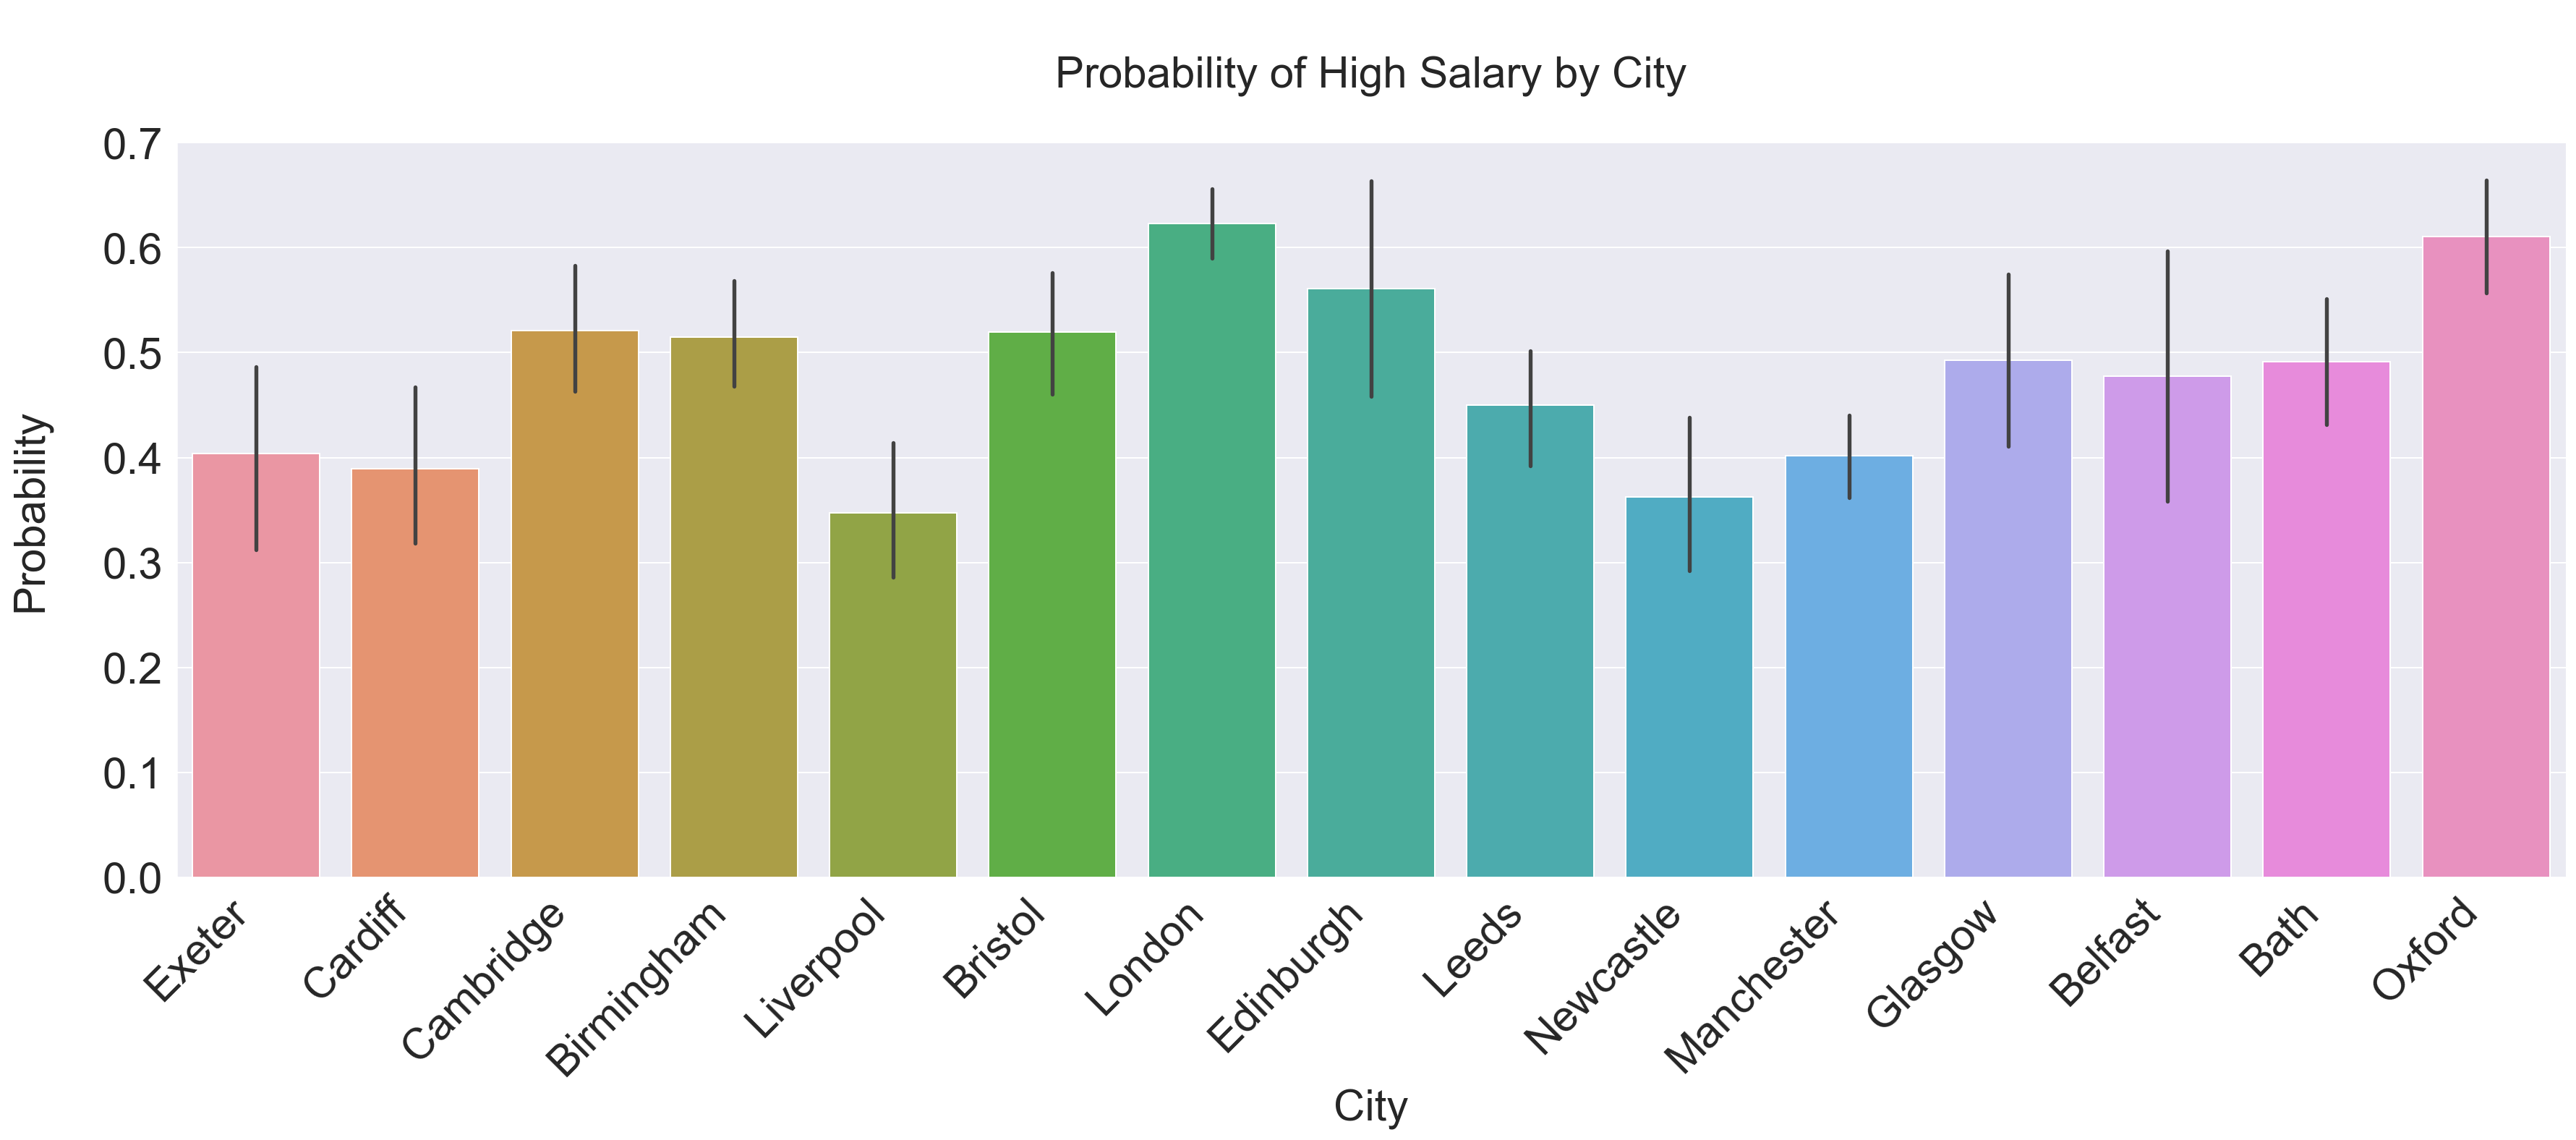

In [169]:
# Display probability of High Salary by City in a factor plot

sns.factorplot(x='City', y='High_Salary', data=df1, kind='bar', aspect=3, size=8, ci=95, 
              ).set_xticklabels(rotation=45, horizontalalignment='right',
              fontsize=30).set_yticklabels(fontsize=30)
plt.xlabel('City',fontsize=30)
plt.ylabel('Probability\n',fontsize=30)
plt.title('\nProbability of High Salary by City\n').set_fontsize(30) ;

In [167]:
df1.groupby('City')['Salary'].count()

City
Bath          283
Belfast        67
Birmingham    408
Bristol       302
Cambridge     259
Cardiff       154
Edinburgh     107
Exeter        109
Glasgow       134
Leeds         329
Liverpool     210
London        809
Manchester    545
Newcastle     171
Oxford        316
Name: Salary, dtype: int64

In [170]:
df1.groupby('City')['High_Salary'].sum()

City
Bath          139
Belfast        32
Birmingham    210
Bristol       157
Cambridge     135
Cardiff        60
Edinburgh      60
Exeter         44
Glasgow        66
Leeds         148
Liverpool      73
London        504
Manchester    219
Newcastle      62
Oxford        193
Name: High_Salary, dtype: int64

In [ ]:
# London has a much higher range of salary than other cities and could skew the scores

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc

In [172]:
# Create predictor matrix and target array

# Define target array
y = df1['High_Salary']

# Define predictor matrix
X = df1[['City']]

# Dumify categorical field in predictor data. Will drop London as it has the highest probability of 
# having jobs with a higher salary and will help with the interpretability of the coefficients
X_dumified = pd.get_dummies(X)
X_dumified.drop('City_London', axis=1, inplace=True)


In [173]:
X_dumified.head()

,City_Bath,City_Belfast,City_Birmingham,City_Bristol,City_Cambridge,City_Cardiff,City_Edinburgh,City_Exeter,City_Glasgow,City_Leeds,City_Liverpool,City_Manchester,City_Newcastle,City_Oxford
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# No need to standardise the predictors the units are the same

In [176]:
# Get the train-test split
# Stratify on target variable to maintain the same proportions of class labels as the input datasets
X_train, X_test, y_train, y_test = train_test_split(X_dumified, y, test_size=0.3,
                                                    stratify=y, random_state=42)

In [177]:
# Instantiate Logistic Regression Model, with very minimal/no regularisation

log_model = LogisticRegression(C=10**10)

In [178]:
# Review cross validation accuracy scores of model on training data.  

scores = cross_val_score(log_model, X_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=42))
print('Accuracy scores: ', scores)
print('Mean accuracy score: ', scores.mean())

Accuracy scores:  [0.55963303 0.58205912 0.54285714]
Mean accuracy score:  0.5615164312412019


***The model's average accuracy score is 0.56 and has performed better than the baseline of 0.50***

In [186]:
# Fit model to training data set
log_model.fit(X_train, y_train)

print(f'Accuracy of the model on training data is: {round(log_model.score(X_train, y_train),2)}.')

Accuracy of the model on training data is: 0.57.


In [187]:
# Predictions based on the test data
predictions = log_model.predict(X_test)

print(f'Accuracy of the model on test set is: {round(accuracy_score(y_test, predictions),2)}.')

Accuracy of the model on test set is: 0.58.


The model has performed better than the training set generalising to the test set and has also performed better than the baseline model. The small number of data points for some of the cities could have an effect on the scores as those may not sufficiently represented in the train-test splits to maintain their signal for both high and low salary classes.

In [188]:
# Display confusion matrix
confusion = confusion_matrix(y_test, predictions)
pd.DataFrame(confusion, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,342,288
Actual High Salary,246,385


In [190]:
# Cross check accuracy score with data in confusion matrix
print(f'Accuracy score from the confusion matrix: {round((confusion[0][0] + confusion[1][1])/confusion.sum(),2)}')

Accuracy score from the confusion matrix: 0.58


In [191]:
# Recall scores in classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56       630
           1       0.57      0.61      0.59       631

    accuracy                           0.58      1261
   macro avg       0.58      0.58      0.58      1261
weighted avg       0.58      0.58      0.58      1261



***The scores from the confusion matrix shows that the model is doing a better job at predicting high salaries vs low salaries***

In [194]:
# Print recall score / true positive rate (tp / tp + fn)
print(f'Recall score/true positive rate is: {round(recall_score(y_test, predictions),2)}')

# Print specicifity / true negative rate (tn / tn + fp)
print(f'Specicity score/true negative rate is: {round(recall_score(y_test==0, predictions==0),2)}')

Recall score/true positive rate is: 0.61
Specicity score/true negative rate is: 0.54


In [195]:
# Use Grid Search to search Logistic Regression hyperparameters to see if model can be improved
# Define logistic regression hyperparameters.  Center C around 0 to maximise regularisation.
# 
salary_gs_params = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-10, 10, 5000),
                    'fit_intercept':[True, False]}

In [196]:
# Create gridsearch object using LogisticRegression() and the hyperparamater dictionary above
salary_gs = GridSearchCV(LogisticRegression(), salary_gs_params, 
                         n_jobs=-1, cv=3, verbose=1)

In [197]:
# Fit gridsearch object to training data
salary_gs.fit(X_train, y_train)

Fitting 3 folds for each of 20000 candidates, totalling 60000 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-10, 1.00925475e-10, 1.01859514e-10, 1.02802198e-10,
       1.03753606e-10, 1.04713819e-10, 1.05682919e-10, 1.06660988e-10,
       1.07648108e-10, 1.08644364e-10, 1.09649840e-10, 1.10664621e-10,
       1.11688794e-10, 1.12722445e-10, 1.13765663e-10, 1.14818535e-10,
       1.15881152e-10, 1.16953602e-1...
       8.39430601e+09, 8.47199317e+09, 8.55039931e+09, 8.62953108e+09,
       8.70939520e+09, 8.78999844e+09, 8.87134763e+09, 8.95344970e+09,
       9.03631160e+09, 9.11994036e+09, 9.20434309e+09, 9.28952694e+09,
       9.37549915e+09, 9.46226701e+09, 9.54983788e+09, 9.63821920e+09,
       9.72741847e+09, 9.81744325e+09, 9.90830119e+09, 1.00000000e+10]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [198]:
# Print out best mean cross validated score of the gridsearch
salary_gs.best_score_     

0.5601635149472632

The cross validated score calculated further up is marginally better than the mean cross validated score calculated here. Tuning the model with the hyperparameters used above did not improve the model

In [199]:
# Print the best hyperparameters that the gridsearch found
salary_gs.best_params_   

{'C': 0.8355729976322723,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [200]:
# assign the best estimator to a variable:
best_log_model = salary_gs.best_estimator_

In [202]:
# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: {round(best_log_model.score(X_train, y_train),2)}.')

The accuracy of the model on the training data is: 0.57.


This accuracy score is the same as the accuracy score achieved with the unregularised model above - which isn't a huge surprise, since the regularisation strength of this best log reg model is very weak (i.e. very similar to the unregularised model used above).

In [204]:
# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: {round(best_log_model.score(X_test, y_test),2)}')

Accuracy score of optimum Logistic Regression model on test data: 0.58


The accuracy score of the best log reg model on the test set is the same as that achieved with the original unregularised model above.

In [206]:
# Test gridsearch results again with hyperparameters defined to focus on higher regularisation strengths
# Fit model and print optimum log reg model parameters.  
salary_gs_params1 = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-3, 3, 6000),
                    'fit_intercept':[True, False]}

salary_gs1 = GridSearchCV(LogisticRegression(), salary_gs_params1, 
                         n_jobs=-1, cv=3, verbose=1)

salary_gs1.fit(X_train, y_train)

salary_gs1.best_params_ 

Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


{'C': 0.8346164004806245,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [207]:
# Print out best mean cross validated score
salary_gs1.best_score_   

0.5601635149472632

The mean cross validated accuracy score is the same as that achieved with the GridSearch above

In [208]:
# Test the optimum Logistic Regression resulting from this second GridSearch
# Assign estimator to best_logreg1
best_log_model1 = salary_gs1.best_estimator_

# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: \
{round(best_log_model1.score(X_train, y_train),2)}.')

# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: \
{round(best_log_model1.score(X_test, y_test),2)}')

The accuracy of the model on the training data is: 0.57.
Accuracy score of optimum Logistic Regression model on test data: 0.58


Again, there is very little difference in the accuracy scores of this optimum log reg model on the training and test data. The model is performing much better than the baseline model and fits well to the test data.

In [209]:
# Define DF with coefficients from unregularised log reg model
df1_coeff = pd.DataFrame({'Coefficients':log_model.coef_[0], 'city':X_train.columns})
df1_coeff.sort_values(by='Coefficients', ascending=False, inplace=True)

print('Log_model intercept:', log_model.intercept_) 
print('\n\n')
print('Log_model coefs:')
df1_coeff

Log_model intercept: [0.5201273]



Log_model coefs:


,Coefficients,city
13,-0.118678,City_Oxford
6,-0.232430,City_Edinburgh
4,-0.412496,City_Cambridge
3,-0.449031,City_Bristol
2,-0.479310,City_Birmingham
0,-0.573620,City_Bath
8,-0.607144,City_Glasgow
1,-0.611099,City_Belfast
9,-0.643086,City_Leeds
5,-0.784303,City_Cardiff


Logistic Regression determines predictor coefficients to maximize the likelihood that the predicted probabilities give the correct class. The optimal case would be that the predicted probabilities for all class one observations (high salaries) are one and the predicted probabilities for all class zero observations (low salaries) are zero.

The coefficients in the logistic regression model represent the change in log-odds due to the input variables and the intercept (0.5201273) is equivalent to the predicted log-odds of a High Salary for the London.

In [210]:
# Modeled probability of a high salary in London using the intercept from the log_model model
modeled_london_prob = round(float(1/(1+np.exp(-(log_model.intercept_)))),2)
print(f'Modeled probability of a high salary in London is {modeled_london_prob}.')

Modeled probability of a high salary in London is 0.63.


This is very close to the probability calculated from the observations for London above.

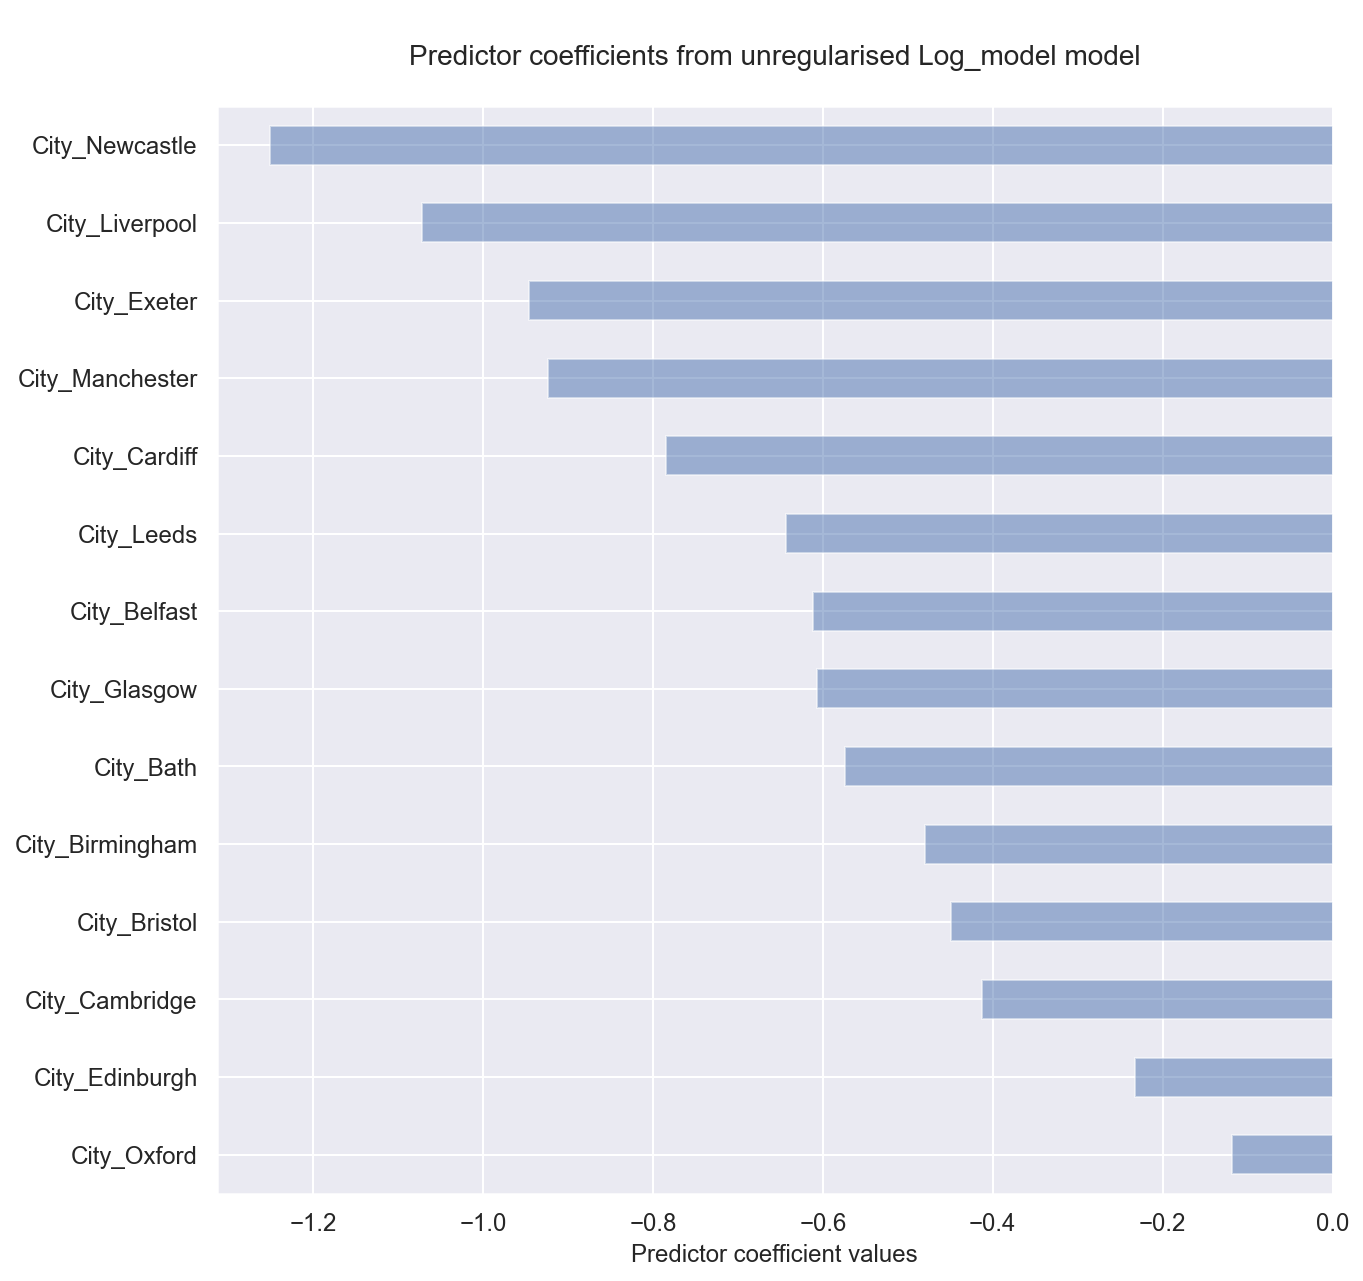

In [212]:
# Plot coefficients from unregularised log reg model above
fig, ax = plt.subplots(figsize=(10,10))
title = '\nPredictor coefficients from unregularised Log_model model\n'
df1_coeff['Coefficients'].plot(kind='barh', ax=ax, alpha=0.5, fontsize=12)
ax.set_yticklabels(df1_coeff['city'])
ax.set_xlabel('Predictor coefficient values', fontsize=12)
ax.set_title(title, fontsize=14);

The plot above shows that all coefficients are negative, meaning that the log odds of all these cities having a high salary are less than that of the dropped column (London).

### 
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [213]:
# Define copy of df (df_t for analysis of Words in job title) and extract the target variable
df_w = df1.copy()
y_w = df_w['High_Salary']

In [214]:
# Split data into training and test sets for analysis of words in Job Title
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(df_w, y_w, test_size=0.3,
                                                            stratify=y_w, random_state=42)

In [215]:
# Create 2 DFs: 1 for High Salaries and 1 for Low Salaries
# Use the CountVectoriser class to analyse the most popular words apearing in Job Titles for both High and Low salaries.
X_train_w1 = X_train_w.loc[X_train_w['High_Salary']==1,:]
X_train_w0 = X_train_w.loc[X_train_w['High_Salary']==0,:]

In [216]:
# Import CountVectorizer to facilitate analysis of language used in Job Titles  
from sklearn.feature_extraction.text import CountVectorizer

In [217]:
# Define CountVectoriser object and use the stop_words argument to remove words like "and, the, a"
cvec1 = CountVectorizer(stop_words='english')
cvec0 = CountVectorizer(stop_words='english')

# Fit the count vectorizer on the Job Title data for both High (class 1) and Low (class 0) salary jobs
cvec1.fit(X_train_w1['Title'])
cvec0.fit(X_train_w0['Title'])

CountVectorizer(stop_words='english')

In [218]:
# Print the number of unique words appearing in Job Titles for both High and Low salary jobs
print(f'Number of unique words appearing in High Salary job titles: {len(cvec1.get_feature_names())}')
print(f'Number of unique words appearing in Low Salary job titles: {len(cvec0.get_feature_names())}')

Number of unique words appearing in High Salary job titles: 841
Number of unique words appearing in Low Salary job titles: 908


There are 8% more unique words appearing in the Job Titles of Low salary jobs, than high salary jobs - suggesting the naming conventions for both higher and lower paid jobs are more or less standard.

In [219]:
# Transform training data (by class) to count the number of unique words appearing in the Job Titles
cvec_mat1 = cvec1.transform(X_train_w1['Title'])
cvec_mat0 = cvec0.transform(X_train_w0['Title'])


In [240]:
# Print percentage occurrence of 20 most frequent words appearing in high salary job titles 
df_cvec1 = pd.DataFrame(cvec_mat1.toarray(), columns=cvec1.get_feature_names())
round(df_cvec1.sum(axis=0).sort_values(ascending=False)[:20] / len(X_train_w1) * 100)

data            23.0
analyst         19.0
senior          19.0
manager         17.0
engineer        15.0
scientist       12.0
business        12.0
developer        9.0
software         5.0
research         5.0
lead             5.0
analytics        4.0
learning         4.0
machine          4.0
intelligence     4.0
bi               4.0
head             4.0
consultant       3.0
science          3.0
digital          3.0
dtype: float64

In [241]:
# Print percentage occurrence of 20 most frequent words appearing in low salary job titles 
df_cvec0 = pd.DataFrame(cvec_mat0.toarray(), columns=cvec0.get_feature_names())
round(df_cvec0.sum(axis=0).sort_values(ascending=False)[:20] / len(X_train_w0) * 100)

analyst          22.0
administrator    16.0
manager          12.0
data             10.0
executive        10.0
marketing        10.0
business          9.0
digital           7.0
research          6.0
senior            5.0
assistant         5.0
sales             4.0
scientist         4.0
engineer          4.0
graduate          4.0
developer         3.0
associate         3.0
specialist        3.0
support           3.0
development       3.0
dtype: float64

##### Features to investigate
- data: appears in 23% of high salary job titles; 10% of low salary job titles
- senior: appears in 19% of high salary job titles; 5% of low salary job titles

In [225]:
# Take copy of DFs to enable insertion of new columns below without warnings
X_train_w = X_train_w.copy()
X_test_w = X_test_w.copy()

In [236]:
# Define list of Job Title keywords
job_title_keywords = ['data', 'senior']

# For each Job Title keyword, check if it's in the Job Title, and flag the job with either a 
# 1 or 0 in a keyword-specific column within the training DF to indicate if the word appears 
# in the Job Title or not.  Also updated the test data DF here.
for label in job_title_keywords:
    X_train_w[label+'_keyword'] = X_train_w['Title'].map(lambda x: 1 if label in x.lower() else 0)
    X_test_w[label+'_keyword'] = X_test_w['Title'].map(lambda x: 1 if label in x.lower() else 0)

In [227]:
X_train_w.head()

,Title,Company,Salary,Description,City,jobs,High_Salary,data_keyword,analyst_keyword,senior_keyword,manager_keyword,business_keyword,research_keyword
1249,Digital Marketing Executive / SEO – Recruitment,Mase Consulting,29500,A business that will have your back in the goo...,Liverpool,business analytics,0,0,0,0,0,0,0
3175,Mobile UI / UX Designer - Fully Remote,Carrington Recruitment Solutions,60000,"User research, branding and user journey flow ...",London,research scientist,1,0,0,0,0,0,0
2867,Data Science Engineer,Harnham,65000,Productionising data models and Machine Learni...,Edinburgh,data scientist,1,1,0,0,0,0,0
122,Corporate Information Specialist,University Hospitals Coventry and Warwickshire...,41696,"You will take a strategic approach, initiating...",Birmingham,business intelligence,1,0,0,0,0,0,0
4057,Healthcare Administrator,Tordan Healthcare,20000,Overall responsibility to support the day to d...,Manchester,database administrator,0,0,0,0,0,0,0


In [237]:
# Review how many jobs in the training data have not been flagged with a keyword in their job title

X_train_w['keyword_total'] = X_train_w.iloc[:, 7:13].sum(axis=1)
mask = X_train_w['keyword_total'] == 0
print(f'{round(mask.sum() / len(X_train_w) * 100, 2)}% of jobs from the training data have not been flagged with a keyword.')

42.32% of jobs from the training data have not been flagged with a keyword.


In [238]:
X_train_w.loc[mask, 'Title']

1249      Digital Marketing Executive / SEO – Recruitment
3175               Mobile UI / UX Designer - Fully Remote
122                      Corporate Information Specialist
4057                             Healthcare Administrator
1568    Applications Support Consultant with Test / Pr...
                              ...                        
3980                                  Sales Administrator
1232                                       UX/UI Designer
932                           Digital Marketing Assistant
3199                              CX Leadership Programme
3515                            Machine Learning Engineer
Name: Title, Length: 1245, dtype: object

In [247]:
# Add both 'scien', 'stat' and 'manager' to my list of Job Title keywords
job_title_keywords = ['scien', 'assistant', 'developer', 'learning']

# Repeat the step above, for these 3 additioanl keywords
for label in job_title_keywords:
    X_train_w[label+'_keyword'] = X_train_w['Title'].map(lambda x: 1 if label in x.lower() else 0)
    X_test_w[label+'_keyword'] = X_test_w['Title'].map(lambda x: 1 if label in x.lower() else 0)

In [248]:
# Drop previous keyword_total column
X_train_w.drop('keyword_total', axis=1, inplace=True)

In [249]:
X_train_w.head()

,Title,Company,Salary,Description,City,jobs,High_Salary,data_keyword,analyst_keyword,senior_keyword,manager_keyword,business_keyword,research_keyword,scien_keyword,assistant_keyword,developer_keyword,learning_keyword
1249,Digital Marketing Executive / SEO – Recruitment,Mase Consulting,29500,A business that will have your back in the goo...,Liverpool,business analytics,0,0,0,0,0,0,0,0,0,0,0
3175,Mobile UI / UX Designer - Fully Remote,Carrington Recruitment Solutions,60000,"User research, branding and user journey flow ...",London,research scientist,1,0,0,0,0,0,0,0,0,0,0
2867,Data Science Engineer,Harnham,65000,Productionising data models and Machine Learni...,Edinburgh,data scientist,1,1,0,0,0,0,0,1,0,0,0
122,Corporate Information Specialist,University Hospitals Coventry and Warwickshire...,41696,"You will take a strategic approach, initiating...",Birmingham,business intelligence,1,0,0,0,0,0,0,0,0,0,0
4057,Healthcare Administrator,Tordan Healthcare,20000,Overall responsibility to support the day to d...,Manchester,database administrator,0,0,0,0,0,0,0,0,0,0,0


In [251]:
# Review again how many jobs in the training data have not been flagged with a keyword in their job title
X_train_w['keyword_total'] = X_train_w.iloc[:, 7:17].sum(axis=1)
mask = X_train_w['keyword_total'] == 0
print(f'{round(mask.sum() / len(X_train_w) * 100, 2)}% of jobs from the training data have not been flagged with a keyword.')

32.05% of jobs from the training data have not been flagged with a keyword.


In [254]:
# Define list of columns to drop from the training and test data for the predictor matrices
drop_columns = ['Company', 'Salary', 'Title', 'jobs', 'Description', 'keyword_total']

X_train_wp = X_train_w.drop(drop_columns, axis=1)
X_test_wp = X_test_w.drop(drop_columns[:-1], axis=1) 

In [255]:
# Verify size of precitor matrices and target arrays before modeling
print(X_train_wp.shape)
print(X_test_wp.shape)
print(y_train_w.shape)
print(y_test_w.shape)

(2942, 12)
(1261, 12)
(2942,)
(1261,)


In [256]:
# Verify that all cities are represented in the train and test predictor matrices before dumifying
X_train_wp['City'].value_counts()

London        574
Manchester    407
Birmingham    294
Leeds         228
Oxford        207
Bristol       197
Bath          187
Cambridge     186
Liverpool     156
Newcastle     120
Cardiff        99
Glasgow        92
Exeter         81
Edinburgh      70
Belfast        44
Name: City, dtype: int64

In [257]:
X_test_wp['City'].value_counts()

London        235
Manchester    138
Birmingham    114
Oxford        109
Bristol       105
Leeds         101
Bath           96
Cambridge      73
Cardiff        55
Liverpool      54
Newcastle      51
Glasgow        42
Edinburgh      37
Exeter         28
Belfast        23
Name: City, dtype: int64

In [259]:
# Dumify train and test data separately, dropping the San Francisco column in both
X_train_wp = pd.get_dummies(X_train_wp)
X_train_wp.drop('City_London', axis=1, inplace=True)
X_test_wp = pd.get_dummies(X_test_wp)
X_test_wp.drop('City_London', axis=1, inplace=True)

In [260]:
# Standardise train and test predictor matrices with standard scalar fitted to to the training data
ss = StandardScaler()
ss.fit(X_train_wp)

X_train_wp_ss = ss.transform(X_train_wp)
X_test_wp_ss = ss.transform(X_test_wp)

In [261]:
# Confirm that the mean and standard deviation of each column in the training data are 0 and 1 respectively
pd.DataFrame(X_train_wp_ss, columns=X_train_wp.columns).describe()

,High_Salary,data_keyword,analyst_keyword,senior_keyword,manager_keyword,business_keyword,research_keyword,scien_keyword,assistant_keyword,developer_keyword,...,City_Cambridge,City_Cardiff,City_Edinburgh,City_Exeter,City_Glasgow,City_Leeds,City_Liverpool,City_Manchester,City_Newcastle,City_Oxford
count,2942.00000,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,...,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03,2.942000e+03
mean,0.00000,-1.313814e-16,-2.254409e-16,5.404884e-16,-3.732191e-17,-4.386551e-16,7.601933e-16,-3.837855e-17,1.422497e-16,3.678982e-16,...,5.287711e-16,-2.188747e-16,1.646240e-15,-4.984871e-16,-1.264001e-16,-4.600520e-16,-1.919871e-16,-1.090222e-16,-7.588914e-17,1.118148e-16
std,1.00017,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,...,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00,1.000170e+00
min,-1.00000,-4.601053e-01,-5.114470e-01,-3.733990e-01,-4.092192e-01,-3.338367e-01,-2.437553e-01,-3.468935e-01,-1.766217e-01,-2.575430e-01,...,-2.597867e-01,-1.866075e-01,-1.561194e-01,-1.682610e-01,-1.796683e-01,-2.898428e-01,-2.366311e-01,-4.006897e-01,-2.062111e-01,-2.751101e-01
25%,-1.00000,-4.601053e-01,-5.114470e-01,-3.733990e-01,-4.092192e-01,-3.338367e-01,-2.437553e-01,-3.468935e-01,-1.766217e-01,-2.575430e-01,...,-2.597867e-01,-1.866075e-01,-1.561194e-01,-1.682610e-01,-1.796683e-01,-2.898428e-01,-2.366311e-01,-4.006897e-01,-2.062111e-01,-2.751101e-01
50%,0.00000,-4.601053e-01,-5.114470e-01,-3.733990e-01,-4.092192e-01,-3.338367e-01,-2.437553e-01,-3.468935e-01,-1.766217e-01,-2.575430e-01,...,-2.597867e-01,-1.866075e-01,-1.561194e-01,-1.682610e-01,-1.796683e-01,-2.898428e-01,-2.366311e-01,-4.006897e-01,-2.062111e-01,-2.751101e-01
75%,1.00000,-4.601053e-01,-5.114470e-01,-3.733990e-01,-4.092192e-01,-3.338367e-01,-2.437553e-01,-3.468935e-01,-1.766217e-01,-2.575430e-01,...,-2.597867e-01,-1.866075e-01,-1.561194e-01,-1.682610e-01,-1.796683e-01,-2.898428e-01,-2.366311e-01,-4.006897e-01,-2.062111e-01,-2.751101e-01
max,1.00000,2.173416e+00,1.955237e+00,2.678100e+00,2.443678e+00,2.995477e+00,4.102475e+00,2.882729e+00,5.661818e+00,3.882847e+00,...,3.849312e+00,5.358841e+00,6.405355e+00,5.943146e+00,5.565812e+00,3.450146e+00,4.225988e+00,2.495697e+00,4.849399e+00,3.634909e+00


The mean and standard deviations of all columns are 0 and 1 respectively.

In [262]:
# Reviews cross validation scores of model on training data.  Shuffle, as data will be ordered.
scores = cross_val_score(LogisticRegression(), X_train_wp_ss, y_train_w, cv=KFold(n_splits=3, shuffle=True))
print('Accuracy scores: ', scores)
print('Mean accuracy score: ', scores.mean())

Accuracy scores:  [1. 1. 1.]
Mean accuracy score:  1.0


In [263]:
# Fit logistic regression model to training data set
lr3 = LogisticRegression()
lr3.fit(X_train_wp_ss, y_train_w)

# Print accuracy of model for training set
print(f'The accuracy of the model on the training data is: {round(lr3.score(X_train_wp_ss, y_train_w),2)}.')

The accuracy of the model on the training data is: 1.0.


A significant improvement on the accuracy from the previous models.

In [264]:
# Define model predictions based on the test data and print the accuracy score of the model
predictions3 = lr3.predict(X_test_wp_ss)
# Print accuracy of model for the test set
print(f'The accuracy of the model on the test set is: {round(accuracy_score(y_test_w, predictions3),2)}.')

The accuracy of the model on the test set is: 1.0.


In [265]:
# Use a Gridsearch
salary_gs_params2 = {'penalty':['l1','l2'],
                    'solver':['liblinear'], 
                    'C':np.logspace(-5, 5, 6000),
                    'fit_intercept':[True, False]}

salary_gs2 = GridSearchCV(LogisticRegression(), salary_gs_params2, 
                         n_jobs=-1, cv=3, verbose=1)

salary_gs2.fit(X_train_wp_ss, y_train_w)

Fitting 3 folds for each of 24000 candidates, totalling 72000 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.00384566e-05, 1.00770610e-05, 1.01158140e-05,
       1.01547159e-05, 1.01937675e-05, 1.02329692e-05, 1.02723217e-05,
       1.03118255e-05, 1.03514813e-05, 1.03912895e-05, 1.04312508e-05,
       1.04713659e-05, 1.05116351e-05, 1.05520593e-05, 1.05926389e-05,
       1.06333746e-05, 1.06742669e-0...
       9.29668369e+04, 9.33243555e+04, 9.36832489e+04, 9.40435226e+04,
       9.44051817e+04, 9.47682317e+04, 9.51326778e+04, 9.54985255e+04,
       9.58657801e+04, 9.62344470e+04, 9.66045317e+04, 9.69760396e+04,
       9.73489762e+04, 9.77233470e+04, 9.80991575e+04, 9.84764132e+04,
       9.88551197e+04, 9.92352826e+04, 9.96169075e+04, 1.00000000e+05]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [266]:
# Inspect best params
salary_gs2.best_params_ 

{'C': 0.0005605634415153013,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [267]:
# Print out best mean cross validated score
salary_gs2.best_score_  

1.0

This is an improvement on the mean cross validation accuracy score prior to the GridSearch, which was 0.56.

In [268]:
# Assign optimum Logisitc Regression estimator to best_logreg3
best_logreg2 = salary_gs2.best_estimator_

# Print accuracy score of best log reg model for fit on entire training data set
print(f'The accuracy of the model on the training data is: {round(best_logreg2.score(X_train_wp_ss, y_train_w),2)}.')

# Print accuracy score of best log reg model for fit on the test data
print(f'Accuracy score of optimum Logistic Regression model on test data: {round(best_logreg2.score(X_test_wp_ss, y_test_w),2)}')

The accuracy of the model on the training data is: 1.0.
Accuracy score of optimum Logistic Regression model on test data: 1.0


With the optimum Logistic Regression model identified in the GridSearch, the optimum logistic regression model is generalising better to the test data than the previous model.

In [269]:
# Define predictions based on optimum Logistic Regression model
predictions_w = best_logreg2.predict(X_test_wp_ss)

In [270]:
# Cross check accuracy score calcuated using sklearn with manual calculation
print(f'Manually calculated accuracy score: {round((predictions_w == y_test_w).sum()/len(y_test_w),2)}')

Manually calculated accuracy score: 1.0


In [271]:
# Confusion matrix
confusion = confusion_matrix(y_test_w, predictions_w)
pd.DataFrame(confusion, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,630,0
Actual High Salary,0,631


With the inclusion of keywords from the job titles, reviewing the confusion matrix above reveals that the model is now performing better in the prediction of high salaries than lower salaries. This is a reversal from the model that was using City as a predictor only however, the scores are magnitude of the score forces me to believe that there is possibly some data leakage.

In [272]:
# Cross check accuracy score with data in confusion matrix
print(f'Accuracy score calculated from confusion matrix: {round((confusion[0][0] + confusion[1][1])/confusion.sum(),2)}')

Accuracy score calculated from confusion matrix: 1.0


In [273]:
# Print classification report 
print(classification_report(y_test_w, predictions_w))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       630
           1       1.00      1.00      1.00       631

    accuracy                           1.00      1261
   macro avg       1.00      1.00      1.00      1261
weighted avg       1.00      1.00      1.00      1261



Reviewing the classification report, we see that we had 630 and 631 salaries classified as low and high respectively in the test, target data.

The precision of this model to correctly predict a High Salary is 1 - in 100% of cases where the model predicted a high salary, the actual salary was classified as High). Likewise in 100% of cases where the model predicted a low salary, the actual salary was classified as low. 

According to the recall scores, out of all the salaries classified as High in the test data, the model correctly predicted 100% of these and correctly predicted 100% of low salaries - reinforcing the observation above that the model is performing better in predicting both high salaries and low salaries.
Based on the high scores of the performance of this model would needfurther investigating in the context of reviewing the occurrence of data leakage.

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [274]:
# Calculate probability of predicting high and low salaries using the optimum log reg model above
# Store probabilities in a DF
predictions_w_prob = best_logreg2.predict_proba(X_test_wp_ss)
predictions_w_prob = pd.DataFrame(predictions_w_prob, columns=['Class_0_prob','Class_1_prob'])
predictions_w_prob.head(15)

,Class_0_prob,Class_1_prob
0,0.300002,0.699998
1,0.681682,0.318318
2,0.597706,0.402294
3,0.383737,0.616263
4,0.406533,0.593467
5,0.622795,0.377205
6,0.627700,0.372300
7,0.685906,0.314094
8,0.336537,0.663463
9,0.407018,0.592982


In [275]:
# Show first 15 entries of predictions as a DF to enable easy comparison of predictions with probabilities above
pd.DataFrame(predictions_w, columns=['Class_pred']).head(15)

,Class_pred
0,1
1,0
2,0
3,1
4,1
5,0
6,0
7,0
8,1
9,1


In [276]:
# Add column to predictions_w_prob DF where probability must be greater than 0.6 to predict 
# class 1 (i.e. High salary)
predictions_w_prob['Pred_Class_thresh60'] = [1 if x > 0.60 else 0 
                                             for x in predictions_w_prob.Class_1_prob.values]
predictions_w_prob.head(15)

,Class_0_prob,Class_1_prob,Pred_Class_thresh60
0,0.300002,0.699998,1
1,0.681682,0.318318,0
2,0.597706,0.402294,0
3,0.383737,0.616263,1
4,0.406533,0.593467,0
5,0.622795,0.377205,0
6,0.627700,0.372300,0
7,0.685906,0.314094,0
8,0.336537,0.663463,1
9,0.407018,0.592982,0


By comparing the predicted class (Class_pred) with the predicted probabilities of each class (Class_0_prob and Class_1_prob) we can see that a threshold of 0.5 probability is being used to differentiate between the predicted classification of salaries as either high or low. This means that if the predicted probability of a high class is greater than 0.5, the predicted classification for that salary will also be high.

If my boss would prefer to incorrectly predicting low salaries rather than high salaries, then the model must use a probability higher than 0.5 to classify salaries as either high or low. Increasing the probability to 0.6 for example, would mean that a predicted probability of greater than 0.6 is required for the model to predict the classification of a salary as High.

In [277]:
# Define predictions for threshold probability = 0.6
predictions_w_60 = predictions_w_prob['Pred_Class_thresh60'].values

In [278]:
# Define variables to store number of predictions classified as high for 0.5 and 0.6 probabilities
high_50 = predictions_w.sum()
high_60 = predictions_w_60.sum()
num_pred = len(predictions_w)

print(f'With the probability threshold for differentiating between High and Low salaries increased from 0.5 to 0.6, the number of salaries predicted by the model as \
being: \n \t - high, has decreased from {high_50} to {high_60}\
\n \t - low, has increased from {num_pred - high_50} to {num_pred - high_60}.')

With the probability threshold for differentiating between High and Low salaries increased from 0.5 to 0.6, the number of salaries predicted by the model as being: 
 	 - high, has decreased from 631 to 590
 	 - low, has increased from 630 to 671.


In [279]:
# Display confusion matrix for original model predictions (i.e. probability threshold = 0.5)
confusion_50 = confusion_matrix(y_test_w, predictions_w)
pd.DataFrame(confusion_50, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,630,0
Actual High Salary,0,631


In [280]:
# Display confusion matrix for revised model predictions (i.e. probability threshold = 0.6)
confusion_60 = confusion_matrix(y_test_w, predictions_w_60)
pd.DataFrame(confusion_60, columns=['Predicted Low Salary', 'Predicted High Salary'], 
             index=['Actual Low Salary', 'Actual High Salary'])

,Predicted Low Salary,Predicted High Salary
Actual Low Salary,630,0
Actual High Salary,41,590


The numbers of salaries predicted as high and low as depicted in the confusion matrices aligns with the manual calculations above. There is a significant increase in the number of salaries predicted as low, as the probability threshold fo classifying salaries as high has increased.

In [281]:
# Calculate false positive rates (fp / (tn + fp)) for both probability thresholds 
fpr_50 = round(confusion_50[0][1] / (confusion_50[0][1] + confusion_50[0][0]),2)
fpr_60 = round(confusion_60[0][1] / (confusion_60[0][1] + confusion_60[0][0]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the false positive rate has decreased from {fpr_50} to {fpr_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the false positive rate has decreased from 0.0 to 0.0.


In [282]:
# Calculate true negative rate ((tn / tn + fp)) for both probability thresholds
tnr_50 = round(confusion_50[0][0] / (confusion_50[0][0] + confusion_50[0][1]),2)
tnr_60 = round(confusion_60[0][0] / (confusion_60[0][0] + confusion_60[0][1]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the true negative rate has increased from {tnr_50} to {tnr_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the true negative rate has increased from 1.0 to 1.0.


In [283]:
# Calculate model accuracy for both probability thresholds
accuracy_50 = round(accuracy_score(y_test_w, predictions_w),2)
accuracy_60 = round(accuracy_score(y_test_w, predictions_w_60),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model accuracy has decreased from {accuracy_50} to {accuracy_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model accuracy has decreased from 1.0 to 0.97.


In [285]:
# Calculate false negative rates ((fn / (tp + fn)) for both probability thresholds
fnr_50 = round(confusion_50[1][0] / (confusion_50[1][0] + confusion_50[1][1]),2)
fnr_60 = round(confusion_60[1][0] / (confusion_60[1][0] + confusion_60[1][1]),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model\'s false negative rate has increased from {fnr_50} to {fnr_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model's false negative rate has increased from 0.0 to 0.06.


In [286]:
# Print the precision scores for both models
prec_50 = round(precision_score(y_test_w, predictions_w),2)
prec_60 = round(precision_score(y_test_w, predictions_w_60),2)

print(f'With the increase in the probability threshold from 0.5 to 0.6, the model\'s precision score has increased from {prec_50} to {prec_60}.')

With the increase in the probability threshold from 0.5 to 0.6, the model's precision score has increased from 1.0 to 1.0.


The model has a greater precision in predicting high salaries, which is aligned with my boss' request.

In [287]:
# Print the clasification report for both models
print('\nClassification report for model using 0.5 probability threshold...')
print(classification_report(y_test_w, predictions_w))
print('\n\nClassification report for model using 0.6 probability threshold...')
print(classification_report(y_test_w, predictions_w_60))


Classification report for model using 0.5 probability threshold...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       630
           1       1.00      1.00      1.00       631

    accuracy                           1.00      1261
   macro avg       1.00      1.00      1.00      1261
weighted avg       1.00      1.00      1.00      1261



Classification report for model using 0.6 probability threshold...
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       630
           1       1.00      0.94      0.97       631

    accuracy                           0.97      1261
   macro avg       0.97      0.97      0.97      1261
weighted avg       0.97      0.97      0.97      1261



From the classification reports above:

- the precision score for predicting high salaries has remained at 1.0
- the precision score for predicting low salaries has decreased signficantly from 1.0 to 0.94, because the higher probability threshold results in the model misclassifying a greater number of salaries as low
- the recall score for predicting high salaries has decreased  from 1.0 to 0.94.  
- the recall score for predicting low salaries remained at 1.0.

Plot ROC curve for best_logreg2 model. This was the model that used City, High_Salary and Job Title keywords 

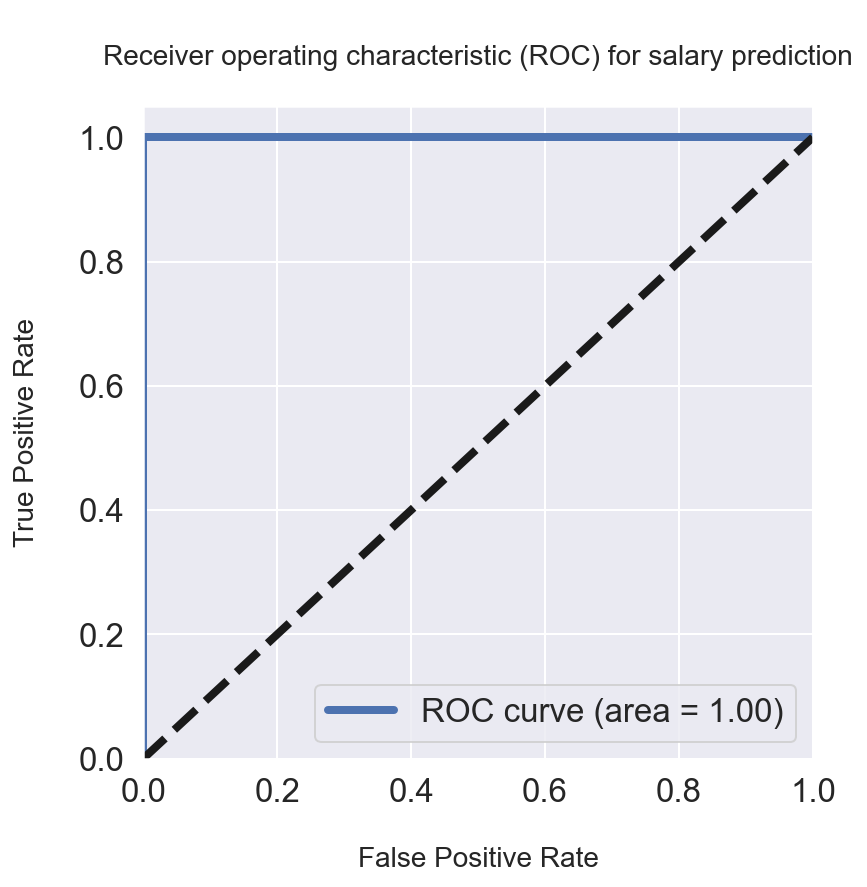

In [288]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test_w, predictions_w_prob['Class_1_prob'])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (high salary)
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('\nFalse Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate\n', fontsize=14)
plt.title('\nReceiver operating characteristic (ROC) for salary prediction\n', fontsize=14)
plt.legend(loc="lower right")
plt.show()

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 